In [3]:
!pip install eTaPR-1.12-py3-none-any.whl

In [3]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange
from TaPR_pkg import etapr
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential,load_model
from keras.layers import Concatenate,Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,TimeDistributed,Lambda, Dense, Flatten, concatenate

Using TensorFlow backend.


## 데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

In [4]:
TRAIN_DATASET = sorted([x for x in Path("data/HAI_2.0/training/").glob("*.csv")])
TRAIN_DATASET

[WindowsPath('data/HAI_2.0/training/train1.csv'),
 WindowsPath('data/HAI_2.0/training/train2.csv'),
 WindowsPath('data/HAI_2.0/training/train3.csv')]

In [5]:
VALIDATION_DATASET = sorted([x for x in Path("data/HAI_2.0/validation/").glob("*.csv")])
VALIDATION_DATASET

[WindowsPath('data/HAI_2.0/validation/validation.csv')]

In [6]:
TEST_DATASET = sorted([x for x in Path("data/HAI_2.0/testing/").glob("*.csv")])
TEST_DATASET

[WindowsPath('data/HAI_2.0/testing/test1.csv'),
 WindowsPath('data/HAI_2.0/testing/test2.csv'),
 WindowsPath('data/HAI_2.0/testing/test3.csv'),
 WindowsPath('data/HAI_2.0/testing/test4.csv')]

In [7]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    len_train=[]
    for x in targets:
        len_train.append(dataframe_from_csv(x).shape[0])
    return pd.concat([dataframe_from_csv(x) for x in targets]),len_train

In [8]:
TRAIN_DF_RAW,len_Train = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


In [9]:
VALIDATION_DF_RAW,len_Val = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [10]:
TEST_DF_RAW, len_test = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


In [11]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [12]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS].max()

In [13]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [14]:
Train_DF_norm = normalize(TRAIN_DF_RAW[VALID_COLUMNS])
Validation_DF_norm = normalize(VALIDATION_DF_RAW[VALID_COLUMNS])
Test_DF_norm = normalize(TEST_DF_RAW[VALID_COLUMNS])

In [15]:
zero_list_train=[]
for i in Train_DF_norm.columns:
    if Train_DF_norm[i].min()==Train_DF_norm[i].max():
        zero_list_train.append(i)

In [16]:
zero_list_val=[]
for i in Validation_DF_norm.columns:
    if Validation_DF_norm[i].min()==Validation_DF_norm[i].max():
        zero_list_val.append(i)

In [17]:
zero_list_test=[]
for i in Test_DF_norm.columns:
    if Test_DF_norm[i].min()==Test_DF_norm[i].max():
        zero_list_test.append(i)

In [18]:
real_zero=[]
for j in zero_list_train:
    if j in zero_list_val and j in zero_list_test:
        real_zero.append(j)

In [19]:
Train_DF_norm      = Train_DF_norm.drop(real_zero,axis=1)
Validation_DF_norm = Validation_DF_norm.drop(real_zero,axis=1)
Test_DF_norm       = Test_DF_norm.drop(real_zero,axis=1)

In [20]:
Train_DF_norm.shape#60 20 10 5 5 10 20 60

(921603, 60)

In [21]:
Train_DF_norm.shape[1]==Validation_DF_norm.shape[1]

True

In [22]:
Validation_DF_norm.shape[1]==Test_DF_norm.shape[1]

True

In [23]:
Train_DF_norm_np=Train_DF_norm.values

In [24]:
Validation_DF_norm_np=Validation_DF_norm.values

In [25]:
Test_DF_norm_np=Test_DF_norm.values

In [26]:
len_Train

[216001, 226801, 478801]

In [27]:
len_Val

[43201]

In [28]:
len_test

[118801, 108001, 39601, 92401]

In [32]:
def make_Matrix(df_norm_clear_np,stride, win_size,len_size):
    X=[]
    skip=0
    for i in len_size:
        n_window = i-win_size+1
        
        for w in range(int(n_window/stride)):
            temp=df_norm_clear_np[skip+w*stride : skip+ w*stride+win_size]
            X.append(np.dot(temp.T, temp))
        skip=skip+i
    return  np.asarray(X)

In [28]:
Train_matrix=make_Matrix(Train_DF_norm_np,4,20,len_Train)

In [95]:
Train_matrix.shape

NameError: name 'Train_matrix' is not defined

In [33]:
Validation_Matrix=make_Matrix(Validation_DF_norm_np,1,20,len_Val)

In [34]:
Validation_Matrix.shape

(43182, 60, 60)

In [86]:
del Train_matrix

In [35]:
Test_Matrix=make_Matrix(Test_DF_norm_np,1,20,len_test)


In [36]:
sum(len_test)

358804

In [37]:
Test_Matrix.shape

(358728, 60, 60)

In [30]:
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


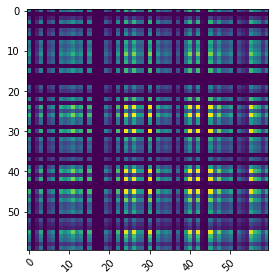

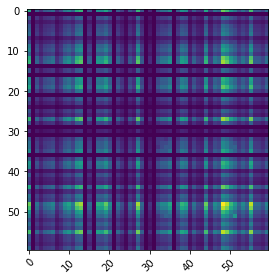

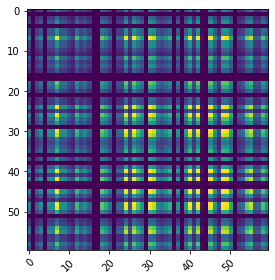

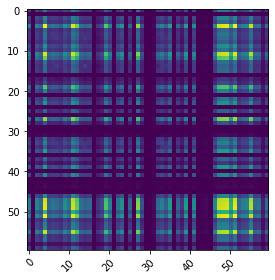

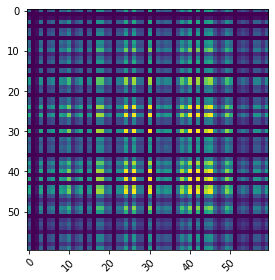

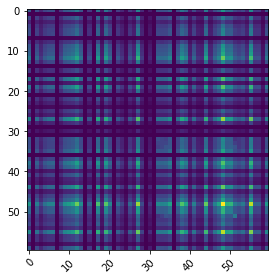

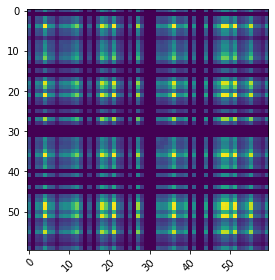

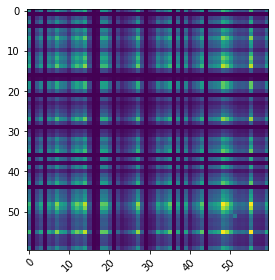

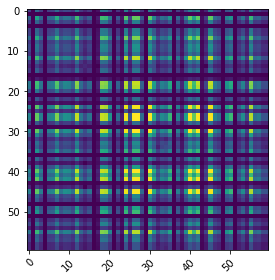

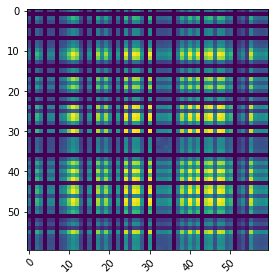

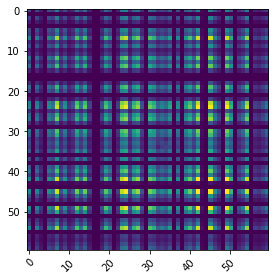

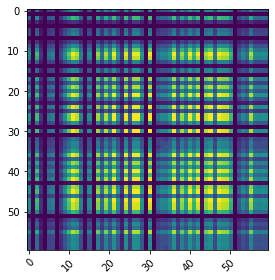

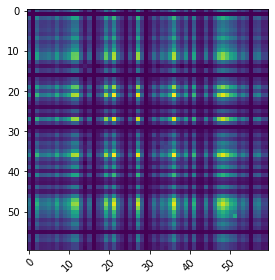

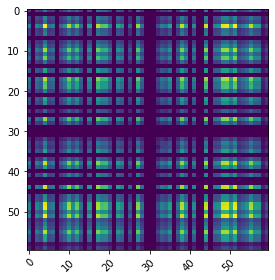

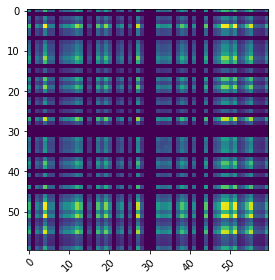

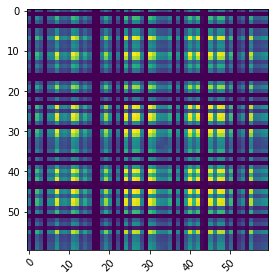

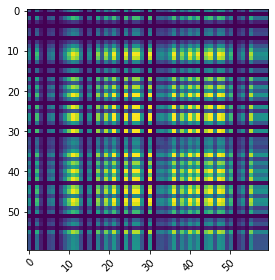

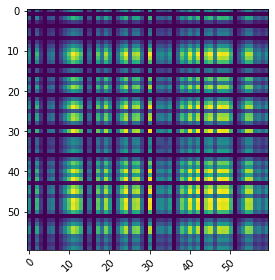

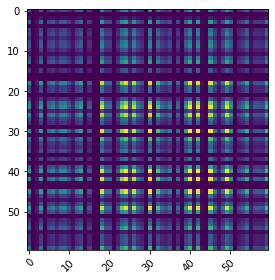

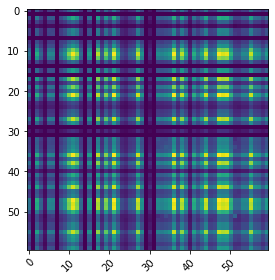

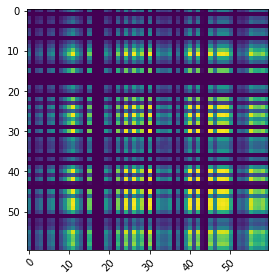

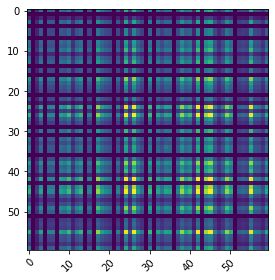

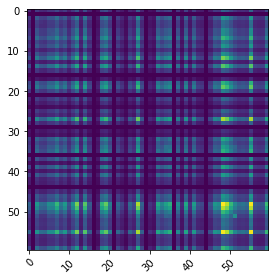

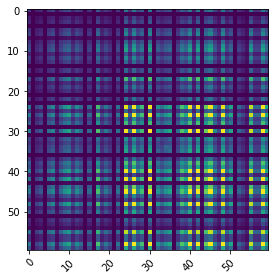

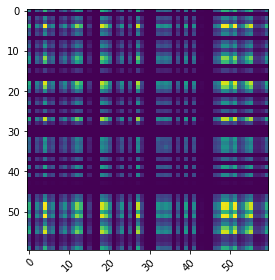

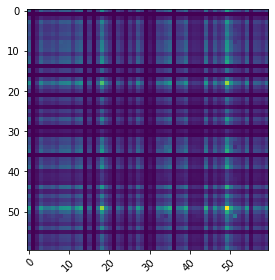

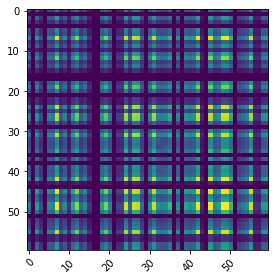

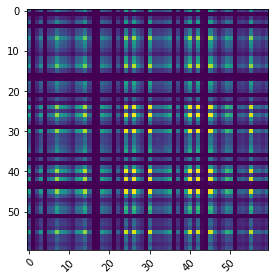

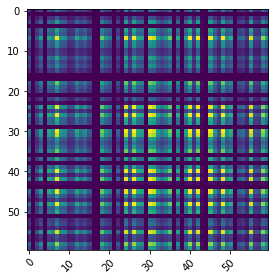

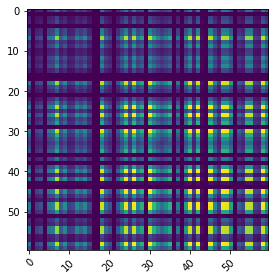

In [88]:
import random as rnd
for i in range(30):
    fig, ax = plt.subplots()
    im = ax.imshow(Test_Matrix[rnd.randrange(0,len(Test_Matrix))])


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    fig.tight_layout()
    plt.show()

# DATA preprocessing End

#DATA Train Start

In [32]:
from keras.layers import Reshape
from keras.backend import mean

In [33]:
import tensorflow as tf

In [39]:
from keras import backend as K
def my_loss(y_true, y_pred):
    loss =  K.mean(K.square(y_true - y_pred))
    return loss

In [35]:
input_img = Input(shape=Train_matrix[0].shape)  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
x = Reshape((60, 60, 1))(input_img)
x = Conv2D(32, (2, 2), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (2, 2), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (2, 2), activation='tanh', padding='same')(x)
encoded = MaxPooling2D((3, 3), padding='same')(x)

x = Conv2D(128, (2, 2), activation='tanh', padding='same')(encoded)
x = UpSampling2D((3, 3))(x)
x = Conv2D(64, (2, 2), activation='tanh', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), activation='tanh',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
decoded=Reshape((60, 60))(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=my_loss)

In [36]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       3289

In [43]:
es = EarlyStopping(monitor='loss', restore_best_weights=True, patience=20)
autoencoder.fit(Train_matrix,Train_matrix, epochs=20000, batch_size=1024, shuffle=True, callbacks=[es])

Epoch 1/20000
230385/230385 [==============================] - 45s 194us/step - loss: 8.3481
Epoch 2/20000
230385/230385 [==============================] - 42s 182us/step - loss: 8.3329
Epoch 3/20000
230385/230385 [==============================] - 40s 174us/step - loss: 8.31470s - loss: 8.31
Epoch 4/20000
230385/230385 [==============================] - 39s 168us/step - loss: 8.3016
Epoch 5/20000
230385/230385 [==============================] - 40s 172us/step - loss: 8.2911
Epoch 6/20000
230385/230385 [==============================] - 38s 166us/step - loss: 8.2773
Epoch 7/20000
230385/230385 [==============================] - 39s 168us/step - loss: 8.2651
Epoch 8/20000
230385/230385 [==============================] - 39s 169us/step - loss: 8.2566
Epoch 9/20000
230385/230385 [==============================] - 39s 168us/step - loss: 8.2436
Epoch 10/20000
230385/230385 [==============================] - 40s 172us/step - loss: 8.2323
Epoch 11/20000
230385/230385 [========================

230385/230385 [==============================] - 43s 187us/step - loss: 8.0219
Epoch 88/20000
230385/230385 [==============================] - 44s 191us/step - loss: 8.01962s - 
Epoch 89/20000
230385/230385 [==============================] - 44s 191us/step - loss: 8.0206
Epoch 90/20000
230385/230385 [==============================] - 44s 191us/step - loss: 8.0189
Epoch 91/20000
230385/230385 [==============================] - 43s 187us/step - loss: 8.0174
Epoch 92/20000
230385/230385 [==============================] - 43s 188us/step - loss: 8.0163
Epoch 93/20000
230385/230385 [==============================] - 43s 186us/step - loss: 8.0173
Epoch 94/20000
230385/230385 [==============================] - 43s 189us/step - loss: 8.0164
Epoch 95/20000
230385/230385 [==============================] - 44s 190us/step - loss: 8.0151
Epoch 96/20000
230385/230385 [==============================] - 43s 188us/step - loss: 8.0161
Epoch 97/20000
230385/230385 [==============================] - 43s 18

KeyboardInterrupt: 

In [44]:
autoencoder.save("AE_v2.h5")

In [40]:
model = load_model('AE_v2.h5', custom_objects={'my_loss': my_loss})

In [46]:
y_val_predict = model.predict(Validation_Matrix)

In [47]:
DIST=np.zeros(len(y_val_predict))
for i in range(len(y_val_predict)):
    DIST[i]=np.mean((Validation_Matrix[i]-y_val_predict[i])**2)

In [48]:
DIST.shape

(43182,)

In [49]:
CHECK_ATT=VALIDATION_DF_RAW["attack"]

In [53]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [51]:
DIST

array([10.90442444, 10.85704478, 10.81695128, ..., 10.46821256,
       10.51898761, 10.56547605])

In [72]:
blank_for_NAN=np.zeros(19)
ANOMALY_SCORE_for_graph=np.concatenate((blank_for_NAN,DIST),axis=0)


inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

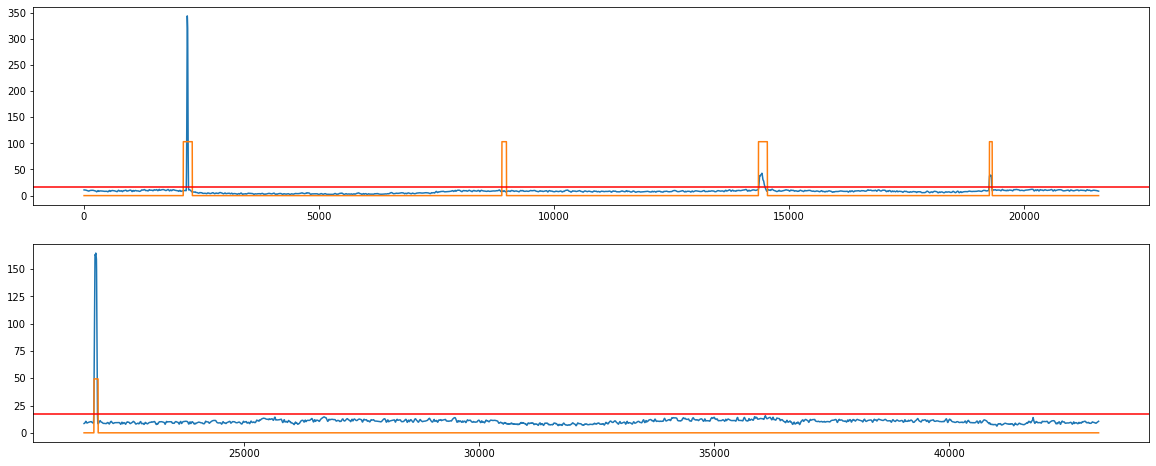

In [73]:
THRESHOLD = 17
check_graph(DIST, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

주황색 선은 공격 위치를 나타내고, 파란색 선은 (평균) 오차의 크기를 나타냅니다.
전반적으로 공격 위치에서 큰 오차를 보이고 있습니다.

임의의 threshold(빨간색 선)가 넘어갈 경우 공격으로 간주합니다.
공격은 1로 정상은 0으로 표기합니다.

In [74]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다.
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.

In [75]:
LABELS = put_labels(DIST, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (43182,))

In [76]:
list(LABELS).count(1)

313

정답지(ATTACK_LABELS)도 동일하게 추출합니다.
검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기하고 있습니다.
위에 정의한 put_labels 함수를 이용해서 0.5를 기준으로 같은 방식으로 TaPR을 위한 label을 붙여줍니다.

In [77]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (43201,))

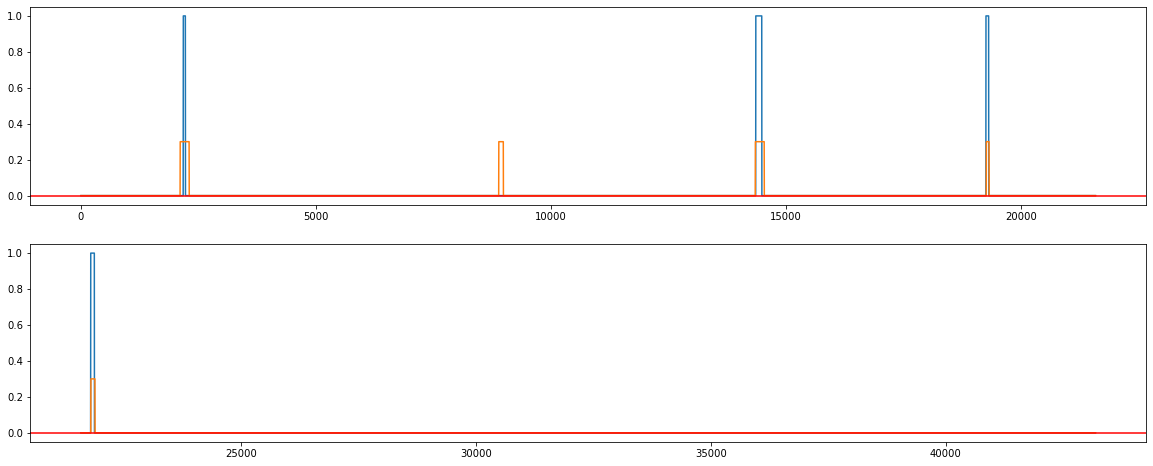

In [78]:
check_graph(LABELS, ATTACK_LABELS, piece=2, THRESHOLD=0)

In [79]:
LABELS.shape

(43182,)

In [82]:
blank_for_NAN=np.zeros(19)
Final_Labels=np.concatenate((blank_for_NAN,LABELS),axis=0)


## 평가

평가는 TaPR을 사용합니다.
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인합니다.

In [83]:
ATTACK_LABELS.shape[0] == Final_Labels.shape[0]

True

TaPR 점수를 받습니다.

In [84]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=Final_Labels)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.809 (TaP: 1.000, TaR: 0.679)
# of detected anomalies: 4
Detected anomalies: ['1', '3', '4', '5']


In [85]:
len_test

[118801, 108001, 39601, 92401]

In [43]:
test_label=[]
skip=0
blank_for_NAN=np.zeros(19)
concated=np.array([])
for i in len_test:
    y_test_predict = model.predict(Test_Matrix[skip:skip+i])
    DIST=np.zeros(len(y_test_predict))
    for j in range(len(y_test_predict)):
        DIST[j]=np.mean((Test_Matrix[skip+j]-y_test_predict[j])**2)
    print(DIST.shape)
    blank_for_NAN=np.zeros(19)
    ANOMALY_SCORE=np.concatenate((blank_for_NAN,DIST),axis=0)
    concated=np.concatenate((concated,ANOMALY_SCORE),axis=0)
    skip=skip+i-19

(118782,)
(107982,)
(39582,)
(92382,)


In [49]:
sum(len_test)

358804

In [48]:
concated.shape

(358804,)

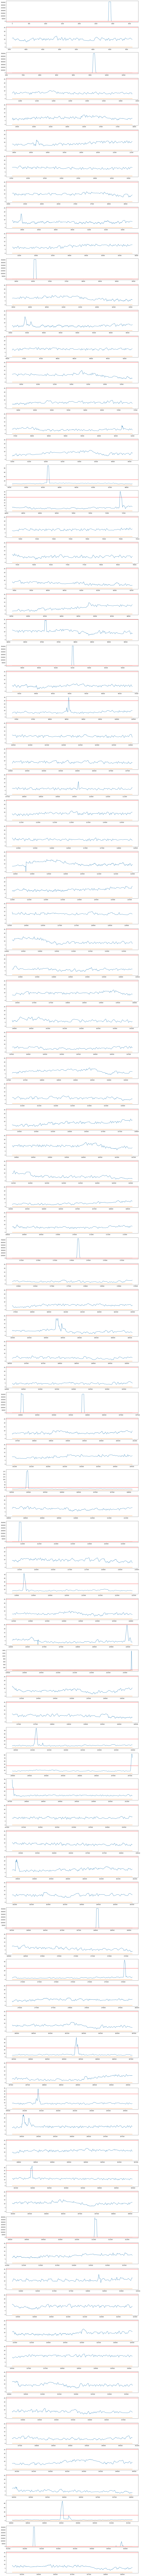

In [62]:
cheak=np.zeros(len(concated))
THRESHOLD = 25
check_graph(concated, cheak, piece=100, THRESHOLD=THRESHOLD)

In [58]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [63]:
LABELS = put_labels(concated, 25)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (358804,))

In [64]:
# 예측한 결과를 제출양식에 맞춰 저장합니다.

submission = pd.read_csv('data/HAI_2.0/sample_submission.csv')
submission.index = submission['time']
submission['attack'] = LABELS
submission
# 예측한 결과를 저장하여 제출합니다.

submission.to_csv('baseline3.csv', index=False)

In [65]:
submission['attack'].shape

(358804,)